In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

In [3]:
import _pickle as pickle
import random

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
torch.cuda.set_device(0)

In [7]:
%run Model.ipynb

In [8]:
emb = pickle.load(open('./Meta/glove_100d_vectors', 'rb'))
emb.append(np.zeros(100))
emb = torch.Tensor(emb)

In [9]:
urls = pickle.load(open('./Meta/urls', 'rb'))
no_urls = len(urls)

In [10]:
class_mapping = {
    'left': [1, 0, 0, 0, 0],
    'left-center': [0, 1, 0, 0, 0],
    'least': [0, 0, 1, 0, 0],
    'right': [0, 0, 0, 0, 1],
    'right-center': [0, 0, 0, 1, 0],
}

In [11]:
def pad_data(data, max_sen_len=50, max_doc_len=90, padding_idx=400003):
    lines = []
    lengths = []
    for doc in data:
        lines.append([])
        lengths.append([])
        for line in doc[2][0:max_doc_len]:
            if len(line) > max_sen_len:
                line = line[0:max_sen_len]
                lengths[-1].append(max_sen_len)
            else:
                lengths[-1].append(len(line))
                line = line + [padding_idx for _ in range(max_sen_len - len(line))]
            lines[-1].append(line)
    return lines, lengths

In [12]:
def pad_titles(data, max_sen_len=20, padding_idx=400003):
    lines = []
    for row in data:
        line = row[0]
        if len(line) > max_sen_len:
            lines.append(line[0:max_sen_len])
        else:
            lines.append(line + [padding_idx for _ in range(max_sen_len - len(line))])
    return lines

In [21]:
class TrainModel():
    def __init__(self, model):
        self.model = model
        self.raw_data, self.lines, self.pad_lengths, self.truth, self.class_, self.urls = None, None, None, None, None, None
        self.file_no = 1
        self.max_file_no = 8
        self.batch_size = 20
        
        self.loss1 = nn.BCEWithLogitsLoss()
        self.loss2 = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters())
        self.losses = []
        
    def __get_next_batch(self):
        pass
    
    def __load_next(self):
        self.raw_data = pickle.load(open('training_' + str(self.file_no), 'rb'))
        self.lines, self.pad_lengths = pad_data(self.raw_data)
        self.class_ = [class_mapping[row[-1]] for row in self.raw_data]
        self.truth = [int(row[-2]) for row in self.raw_data]
        self.lengths = [[] for _ in range(90)]
        for i, j in enumerate(self.lines):
            if not len(j) == 0:
                self.lengths[len(j) - 1].append(i)
        self.urls = [i[1][0:90] for i in self.raw_data]
        self.batches = []
        for unit in self.lengths:
            for i in range(0, len(unit), self.batch_size):
                self.batches.append(unit[i:i+self.batch_size])
        self.titles = pad_titles(self.raw_data)
        random.shuffle(self.batches)
        self.file_no += 1
                
    def train_epoch(self):
        while self.file_no < self.max_file_no:
            self.__load_next()
            for batch in self.batches:
                if len(batch) == 20:
                    self.model.zero_grad()
                    input = torch.cuda.LongTensor([self.lines[i] for i in batch])
                    urls = torch.cuda.LongTensor([self.urls[i] for i in batch])
                    titles = torch.cuda.LongTensor([self.titles[i] for i in batch])
                    truth = torch.cuda.FloatTensor([[self.truth[i]] for i in batch])
                    bias = torch.cuda.FloatTensor([self.class_[i] for i in batch])
                    pbias, ptruth = self.model(input, urls, titles)
                    self.output = pbias, bias
                    # normal BCE loss
                    loss1 = self.loss2(ptruth, truth)
                    # softmax loss
                    pbias = torch.sum(pbias * bias, dim=1)
                    ones = torch.ones(pbias.size())
                    loss2 = self.loss2(pbias, )
                    loss = loss1 + loss2
                    print(str(self.batches.index(batch)) + ' ' + str(loss), end='\r')
                    self.losses.append(loss.cpu().data)
                    loss.backward()
                    self.optimizer.step()

In [22]:
m = Model(no_urls, emb)
m.cuda()

Model(
  (sentenceEncoder): LSTMSentenceEncoderParallel(
    (embeddings): Embedding(400004, 100, padding_idx=400003)
    (sentenceEncoder): LSTM(100, 150, batch_first=True, bidirectional=True)
  )
  (sourceBias): SourceBiasParallel(
    (trans): Linear(in_features=300, out_features=300, bias=True)
    (source_embeddings): Embedding(210381, 300)
  )
  (documentEncoder): LSTM(300, 300, batch_first=True, bidirectional=True)
  (documentAttention): Attention(
    (trans): Bilinear(in1_features=600, in2_features=300, out_features=1, bias=True)
  )
  (biasMLP): MLP(
    (layer1): Linear(in_features=600, out_features=300, bias=True)
    (layer2): Linear(in_features=300, out_features=5, bias=True)
  )
  (truthMLP): MLP(
    (layer1): Linear(in_features=600, out_features=300, bias=True)
    (layer2): Linear(in_features=300, out_features=1, bias=True)
  )
)

In [23]:
t = TrainModel(m)

In [ ]:
t.train_epoch()

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


In [22]:
import matplotlib.pyplot as plt

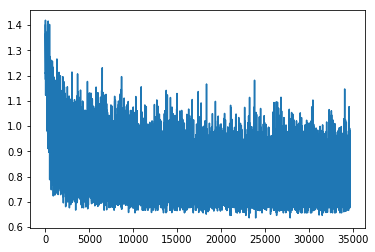

In [23]:
plt.plot(t.losses)

**RESULTS ON VALIDATION SET**

In [24]:
validation_data = pickle.load(open('validation_0', 'rb+'))
validation_data.extend(pickle.load(open('validation_1', 'rb+')))

In [25]:
batch_size = 20

In [26]:
raw_data = validation_data
lines, pad_lengths = pad_data(raw_data)
class_ = [class_mapping[row[-1]] for row in raw_data]
truth = [int(row[-2]) for row in raw_data]
lengths = [[] for _ in range(90)]
for i, j in enumerate(lines):
    if not len(j) == 0:
        lengths[len(j) - 1].append(i)
urls = [i[1][0:90] for i in raw_data]
batches = []
for unit in lengths:
    for i in range(0, len(unit), batch_size):
        batches.append(unit[i:i+batch_size])
titles = pad_titles(raw_data)
random.shuffle(batches)

In [27]:
bias_tp, bias_tn, bias_fp, bias_fn = 0, 0, 0, 0
truth_tp, truth_tn, truth_fp, truth_fn = 0, 0, 0, 0

In [28]:
with torch.no_grad():
    for batch in batches:
        if len(batch) == 20:
            input_ = torch.cuda.LongTensor([lines[i] for i in batch])
            urls_ = torch.cuda.LongTensor([urls[i] for i in batch])
            titles_ = torch.cuda.LongTensor([titles[i] for i in batch])
            truth_ = torch.cuda.FloatTensor([[truth[i]] for i in batch])
            bias_ = torch.cuda.FloatTensor([class_[i] for i in batch])
            pbias, ptruth = t.model(input_, urls_, titles_)

            truth_tp += torch.sum(ptruth.gt(.5) * truth_.gt(0)).cpu().data
            truth_tn += torch.sum(ptruth.le(.5) * truth_.le(0)).cpu().data
            truth_fp += torch.sum(ptruth.gt(.5) * truth_.le(0)).cpu().data
            truth_fn += torch.sum(ptruth.le(.5) * truth_.gt(0)).cpu().data

In [ ]:
precision = truth_tp.long() / (truth_tp + truth_fp).long()
recall = truth_tp.long() / (truth_tp + truth_fn).long()
f1_score = 2 * precision * recall / (precision + recall)
print(f1_score)